# Vehicle Detection and Tracking

The project contains the codebase and algorithm for detection of vehicle in video frame and track them through out the video

The following steps are performed in order build the pipeline for the vehicle dectection algorithm

- Develop a function to draw boxes around give list of co-ordinates
- Peform feature extraction using HOG(Histogram of Oriented Gradients) on training set
- Use a SVM (Support Vector Machine) or another Classifier to train using the features extracted on car, non car data set
- Use sliding window technique on the images from the video using the classifier search for the relevant object.
- Remove false positve using by using heatmaps and outline the detected object in the video frame with annotations

In [5]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import glob
import matplotlib.pyplot as plt
import os
from skimage.feature import hog
import time
from sklearn.preprocessing import StandardScaler
from tqdm import tnrange, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [7]:
# Define path for car and non car image dataset
vehiclespath = "traindb/vehicles"
nonvehiclespath = "traindb/non-vehicles"
vehicleslist = glob.glob(os.path.join(os.path.join(vehiclespath,"*"),"*.png"))
nonvehicleslist = glob.glob(os.path.join(os.path.join(nonvehiclespath,"*"),"*.png"))

## Draw a rectangle function

In [11]:
def draw_rectangle(img, bboxes, color=(0, 255, 0), thick=5):
    '''
    A function to draw rectangle around a give image
    '''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
# test a few sample of test images
test_images = glob.glob("test_images/*.jpg")

In [5]:
bboxes = [((810,400),(955,500)), ((1045,400),(1270,505))]
boxed_test_image = draw_rectangle(mpimg.imread(test_images[0]), bboxes)

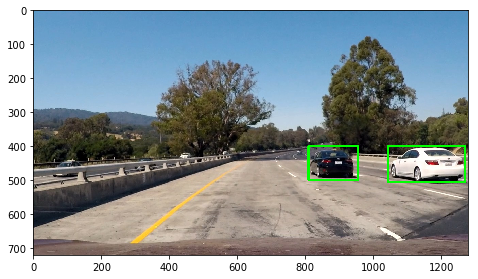

In [6]:
fig = plt.figure(figsize=(8,4.5))
plt.imshow(boxed_test_image)

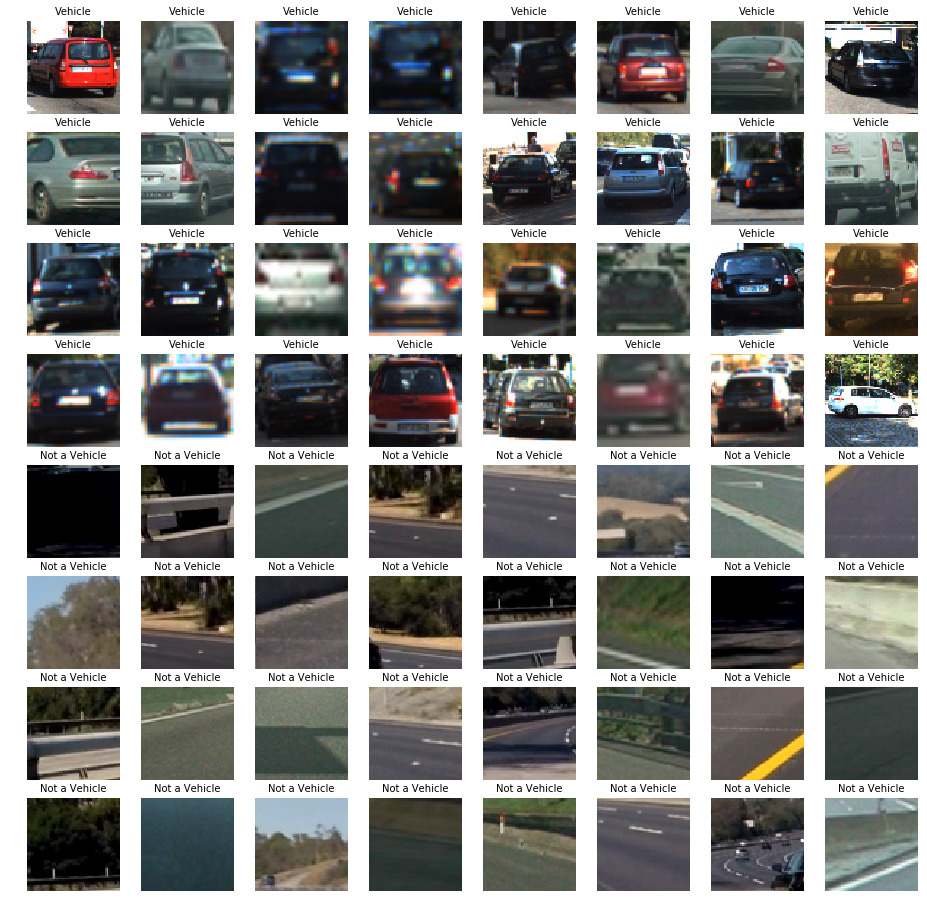

In [49]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = mpimg.imread(vehicleslist[np.random.randint(0,len(vehicleslist))])
    axs[i].set_title('Vehicle', fontsize=10)
    axs[i].axis('off')
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = mpimg.imread(nonvehicleslist[np.random.randint(0,len(nonvehicleslist))])
    axs[i].set_title('Not a Vehicle', fontsize=10)
    axs[i].imshow(img)
    axs[i].axis('off')

## Histogram of Oriented Gradients

A function for histogram of gradient is defined that will extract the hog features from a given image. This will be used to build a dataset of car and non car features set.

In [7]:
# A Hog function using skimage hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features, None

In [8]:
# test a hog feature function performance
def test_hog(imgpath, vis=True):
    testimg = cv2.imread(imgpath)
    testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2GRAY)
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    sttime = time.time()
    if vis:
        feat, himg = get_hog_features(testimg, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    else:
        feat, himg = get_hog_features(testimg, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    endtime = time.time()
    if vis: 
        fig = plt.figure(figsize=(8,4.5))
        plt.subplot(121)
        plt.imshow(testimg, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(himg, cmap='gray')
        plt.title('HOG Visualization')
    print(feat.shape)
    print("Total Time for extraction {} seconds".format(endtime-sttime))

/Users/srikanthnarayanan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1764,)
Total Time for extraction 0.029248952865600586 seconds


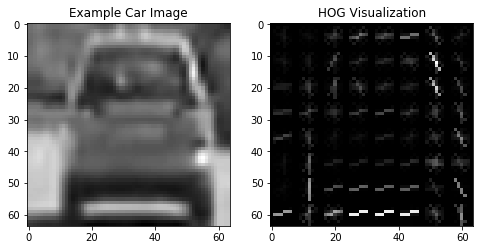

In [9]:
test_hog(vehicleslist[5])

/Users/srikanthnarayanan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1764,)
Total Time for extraction 0.04118204116821289 seconds


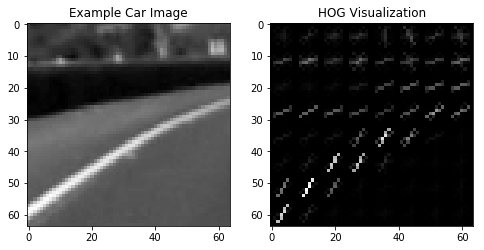

In [10]:
test_hog(nonvehicleslist[5])

### Comparison of Skimage and OpenCV HOG functions

In [8]:
# Skimage Hog Function
def extract_hog_by_skimage(img, color_space='BGR', orient=9, pix_per_cell=8,
                           cell_per_block=2, hog_channel=0, visualise=False, feature_vector=True):
    # Apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Compute HOG features if flag is set
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(hog(feature_image[:,:,channel], orientations=orient,
                                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                                    cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                    visualise=visualise, feature_vector=feature_vector))
    else:
        hog_features = hog(feature_image[:,:,hog_channel], orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                           visualise=visualise, feature_vector=feature_vector)

    # Return concatenated array of features
    return np.ravel(hog_features)

In [12]:
img = cv2.imread(vehicleslist[5])
st_time = time.time()
img_feat = extract_hog_by_skimage(img, color_space='YUV', orient=9, pix_per_cell=8,
                                 cell_per_block=2, hog_channel="ALL")
en_time=time.time()
print(img_feat.shape)
print(en_time-st_time)

(5292,)
0.01180410385131836


/Users/srikanthnarayanan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
hog_channel=["ALL", 0, 1, 2]
time_data = []
color_space='YUV'
orient=9
pix_per_cell=8
cell_per_block=2
for chn in hog_channel:
    st = time.time()
    for idx in tnrange(len(vehicleslist), desc='Vehicle Images'):
        img = cv2.imread(vehicleslist[idx])
        extract_hog_by_skimage(img, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=chn)
    en = time.time()
    time_data.append([color_space, orient, pix_per_cell, cell_per_block, chn, en-st])

pix_per_cell=16
for chn in hog_channel:
    st = time.time()
    for idx in tnrange(len(vehicleslist), desc='Vehicle Images'):
        img = cv2.imread(vehicleslist[idx])
        extract_hog_by_skimage(img, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=chn)
    en = time.time()
    time_data.append([color_space, orient, pix_per_cell, cell_per_block, chn, en-st])

In [15]:
import pandas as pd
df = pd.DataFrame(time_data,columns=['color space', 'orientation', 'pix per cell',
                                     'cell per block', 'channel', 'Extract_Time'])
df

color space  orientation  pix per cell  cell per block channel  Extract_Time
0         YUV            9             8               2     ALL     84.154645
1         YUV            9             8               2       0     26.747634
2         YUV            9             8               2       1     27.399855
3         YUV            9             8               2       2     27.281057
4         YUV            9            16               2     ALL     49.047909
5         YUV            9            16               2       0     16.573284
6         YUV            9            16               2       1     16.791569
7         YUV            9            16               2       2     17.329109

In [18]:
# Skimage Hog Function
def extract_hog_by_opencv(img, color_space='BGR', orient=9, pix_per_cell=8,
                           cell_per_block=2, block_stride=8):
    if (img.shape[0],img.shape[1]) != (64,64):
        img = cv2.resize(img, (64, 64))
    # Apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Compute HOG features if flag is set
    hog = cv2.HOGDescriptor((img.shape[1],img.shape[0]),(pix_per_cell*cell_per_block, pix_per_cell*cell_per_block),
                                (block_stride,block_stride), (pix_per_cell,pix_per_cell), orient)
    hog_features = []        
    hog_features = np.ravel(hog.compute(feature_image))
        
    return hog_features

In [19]:
# Skimage Hog Function
def extract_hog_full(img, color_space='BGR', orient=9, pix_per_cell=8,
                           cell_per_block=2, block_stride=8):
    # Apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Compute HOG features if flag is set
    hog = cv2.HOGDescriptor((img.shape[1],img.shape[0]),(pix_per_cell*cell_per_block, pix_per_cell*cell_per_block),
                                (block_stride,block_stride), (pix_per_cell,pix_per_cell), orient)
    hog_features = []        
    hog_features = np.ravel(hog.compute(feature_image))
        
    return hog_features

In [21]:
img = cv2.imread(vehicleslist[5])
st_time = time.time()
img_feat = extract_hog_by_opencv(img, color_space='BGR', orient=9, pix_per_cell=8,
                                 cell_per_block=2, block_stride=8)
en_time=time.time()
print(np.shape(img_feat))
print(en_time-st_time)

(1764,)
0.0008349418640136719


In [22]:
time_data = []
color_space='YUV'
orient=9
pix_per_cell=[8,16]
cell_per_block=2
for pix in pix_per_cell:
    st = time.time()
    for idx in tnrange(len(vehicleslist), desc='Vehicle Images'):
        img = cv2.imread(vehicleslist[idx])
        extract_hog_by_opencv(img, color_space=color_space, orient=orient, pix_per_cell=pix,
                              cell_per_block=cell_per_block, block_stride=8)
    en = time.time()
    time_data.append([color_space, orient, pix, cell_per_block, "ALL", en-st])

In [23]:
import pandas as pd
df = pd.DataFrame(time_data,columns=['color space', 'orientation', 'pix per cell',
                                     'cell per block', 'channel', 'Extract_Time'])
df

color space  orientation  pix per cell  cell per block channel  Extract_Time
0         YUV            9             8               2     ALL      5.052052
1         YUV            9            16               2     ALL      6.059657

## Dataset preparation

Convert all the training data set images of vehicles and non vehicles in to Hog Feature set that will used for training a classifier

In [17]:
vehicle_hogs = []
for idx in tnrange(len(vehicleslist), desc='Vehicle Images'):
    img = cv2.imread(vehicleslist[idx])
    vehicle_hogs.append(extract_hog_by_opencv(img, color_space='YUV', orient=9, pix_per_cell=8,
                        cell_per_block=2, block_stride=8))

nonvehicle_hogs = []
for idx in tnrange(len(nonvehicleslist), desc='Non-Vehicle Images'):
    img = cv2.imread(nonvehicleslist[idx])
    nonvehicle_hogs.append(extract_hog_by_opencv(img, color_space='YUV', orient=9, pix_per_cell=8,
                        cell_per_block=2, block_stride=8))

In [18]:
print(nonvehicle_hogs[0].shape)
print(vehicle_hogs[0].shape)

(1764,)
(1764,)


## Feature Scaling

Feature scaling normalises the data to zero mean and unit variance. This helps the optimisation process to converge to global minimum for a cost function and hence train better.

In [19]:
# Combine all the features to form a single dataset
X = np.vstack((vehicle_hogs, nonvehicle_hogs)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

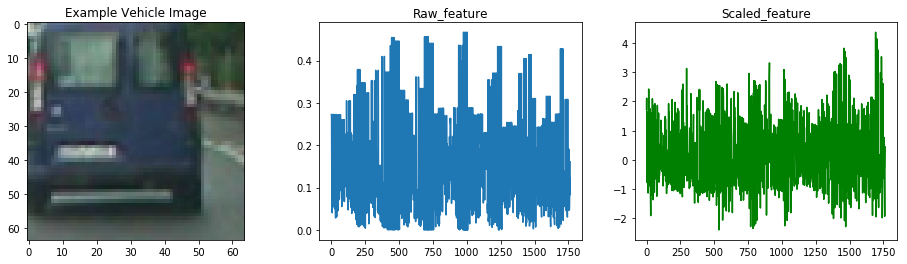

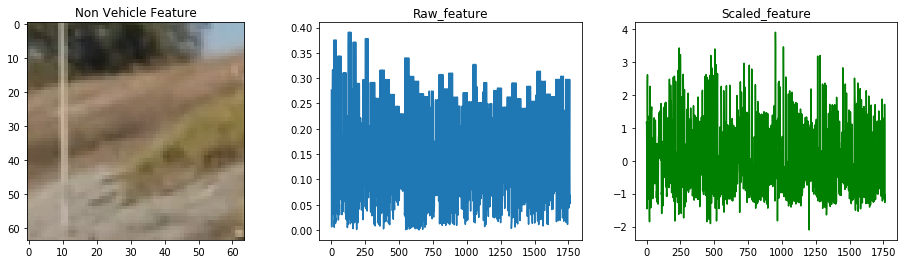

In [20]:
idx = np.random.randint(0,len(vehicleslist))
img = mpimg.imread(vehicleslist[idx])
fig1 = plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img)
plt.title('Example Vehicle Image')
plt.subplot(132)
plt.plot(vehicle_hogs[idx])
plt.title('Raw_feature')
plt.subplot(133)
plt.plot(scaled_X[idx], 'g')
plt.title('Scaled_feature')

## Non Vehicle ##
idx = np.random.randint(0,len(nonvehicleslist))
img = mpimg.imread(nonvehicleslist[idx])
fig2 = plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img)
plt.title('Non Vehicle Feature')
plt.subplot(132)
plt.plot(nonvehicle_hogs[idx])
plt.title('Raw_feature')
plt.subplot(133)
plt.plot(scaled_X[idx], 'g')
plt.title('Scaled_feature')

### Y Label

In order to train the classifier a decision output of whether an object is vehicle or not is provided to the classifier. The Y value for vehicles will be 1 and 0 for non vehicles

In [21]:
y = np.hstack((np.ones(len(vehicleslist)), np.zeros(len(nonvehicleslist))))

## Train a Classifier

A few different types of classifiers will be tested for this identifer and which ever produces the best fit will be used for building the pipeline.

#### Support Vector Machine

In [28]:
# Split Test Train dataset to 80% and 20% respectively
rand_state = np.random.randint(0,1000)
print(rand_state)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

923


In [23]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
st = time.time()
clf.fit(X_train,y_train)
en = time.time()
print ("Time to train SVM {} seconds".format(en-st))
print ("Training Accuracy of SVM {}".format(clf.score(X_train, y_train)))
print ("Test Accuracy of SVM {}".format(clf.score(X_test, y_test)))

Time to train SVM 8.511514902114868 seconds
Training Accuracy of SVM 1.0
Test Accuracy of SVM 0.9518581081081081


In [24]:
st = time.time()
clf.predict([X_test[rand_state]])
en = time.time()
print("Time to predict usinf SVM {} seconds".format(en-st))

Time to predict usinf SVM 0.0004999637603759766 seconds


#### Multi Layer Perceptron

In [29]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=rand_state)
st = time.time()
clf.fit(X_train,y_train)
en = time.time()
print ("Time to train SVM {} seconds".format(en-st))
print ("Training Accuracy of SVM {}".format(clf.score(X_train, y_train)))
print ("Test Accuracy of SVM {}".format(clf.score(X_test, y_test)))

Time to train SVM 14.687026977539062 seconds
Training Accuracy of SVM 1.0
Test Accuracy of SVM 0.9918355855855856


In [30]:
st = time.time()
pprob = clf.predict_proba([X_test[rand_state]])
en = time.time()
print("Time to predict usinf SVM {} seconds".format(en-st))
print(pprob)

Time to predict usinf SVM 0.0010030269622802734 seconds
[[ 0.01577993  0.98422007]]


Visualising Confusion Matrix for the MLP classifier Performance

In [31]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    import pandas as pd
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    print(pd.DataFrame(cm))
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

      0     1
0  1793    10
1    19  1730


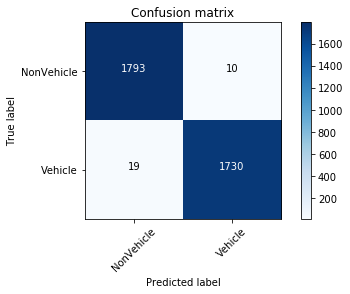

In [32]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(conf_mat, classes=["NonVehicle", "Vehicle"],
                      title='Confusion matrix')

In [33]:
# Saving MLP Classifier to be used by the pipeline
from sklearn.externals import joblib
# Save Dataset
joblib.dump(X_scaler, "X_Scaler.pkl")
joblib.dump(clf, "classifier.pkl")

['classifier.pkl']

## Sliding Window Point Generation for a Given Image size

In [15]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: In general could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [16]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def predictcar(imagepath):
    detected = []
    image = cv2.imread(imagepath)
    dect_img = image.copy()
    win_size = 320

    while win_size < image.shape[0]:
        windows = slide_window(dect_img, x_start_stop=[None, None], y_start_stop=[400,660],
                               xy_window=(win_size, win_size), xy_overlap=(0.8, 0.8))
        # predict for each window if it has a car
        for window in windows:
            curr_img = dect_img[window[0][1]: window[1][1], window[0][0]: window[1][0]]
            hog_feat = extract_hog_by_opencv(curr_img, color_space='YUV')
            scaled_x = X_scaler.transform(hog_feat)
            if curr_img.shape[0] > 0:
                pprob = clf.predict_proba(scaled_x.reshape(1,-1))
                if pprob[0][1] > 0.99:
                    detected.append(window)
        win_size += 10
    return detected
    

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 5)
        cv2.putText(img, 'Vehicle', (bbox[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), thickness=2)
    # Return the image
    return img

In [32]:
def plotsliding(test_images):
    for imgpath in test_images:
        image = mpimg.imread(imgpath)
        plt_img = image.copy()
        win_size = 460
        total_win = []
        while win_size < image.shape[0]:
            windows = slide_window(image.copy(), x_start_stop=[None, None], y_start_stop=[400,660],
                                   xy_window=(win_size, win_size), xy_overlap=(0.8, 0.8))
            total_win.append(windows)
            win_size += 40
        for win in total_win:
            for bbox in win:
            # Draw a rectangle given bbox coordinates
                cv2.rectangle(plt_img, bbox[0], bbox[1], (0,255,0), 2)
        fig = plt.figure(figsize=(16,9))
        plt.subplot(121)
        plt.imshow(image)
        plt.title('Test Image')
        plt.subplot(122)
        plt.imshow(plt_img)
        plt.title('Sliding window')
        fig.tight_layout()

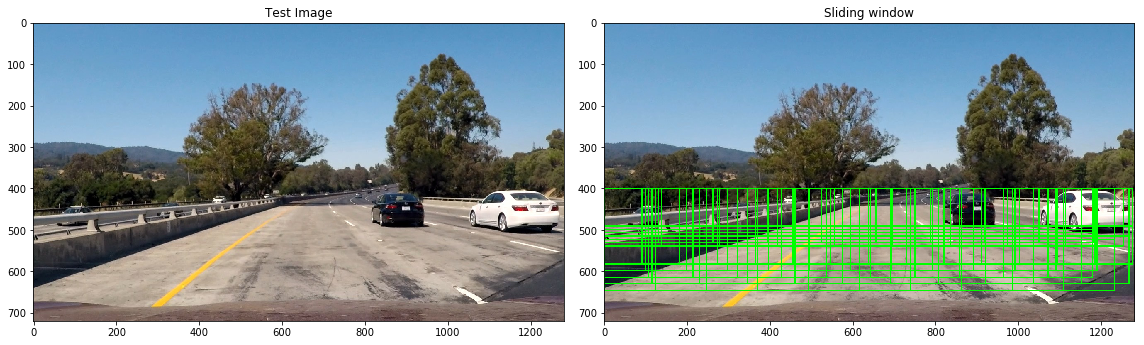

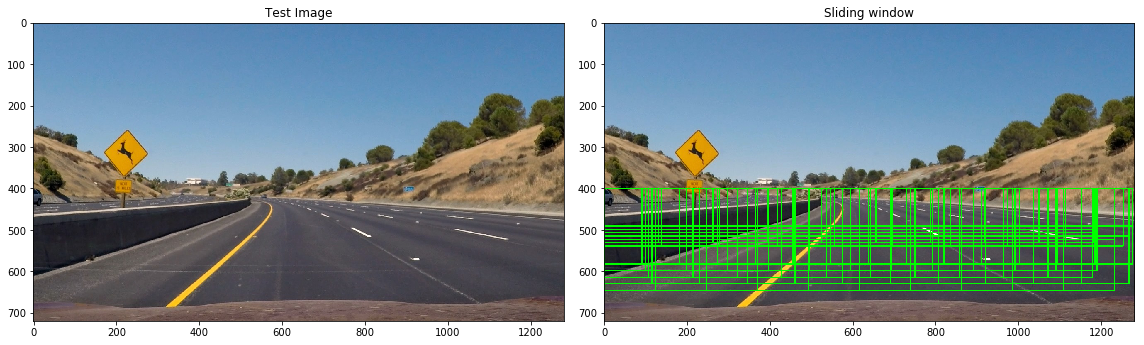

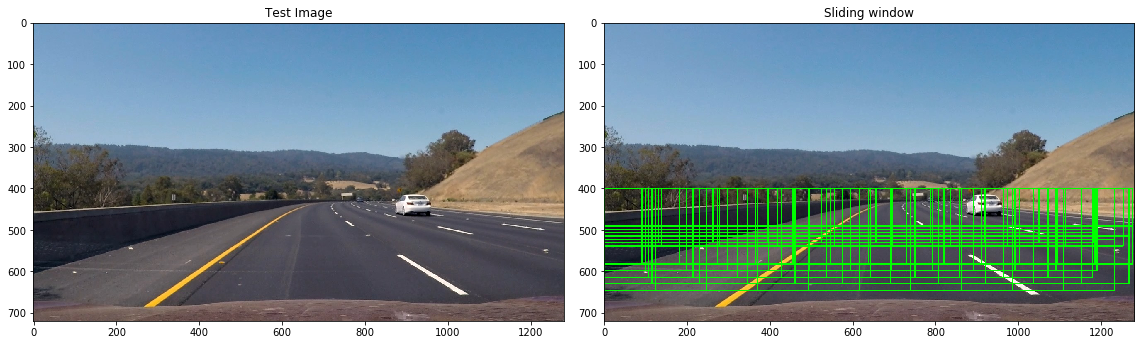

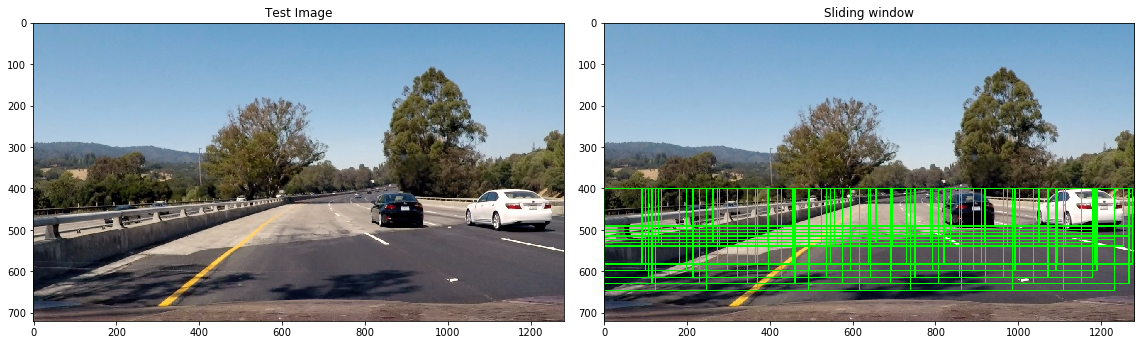

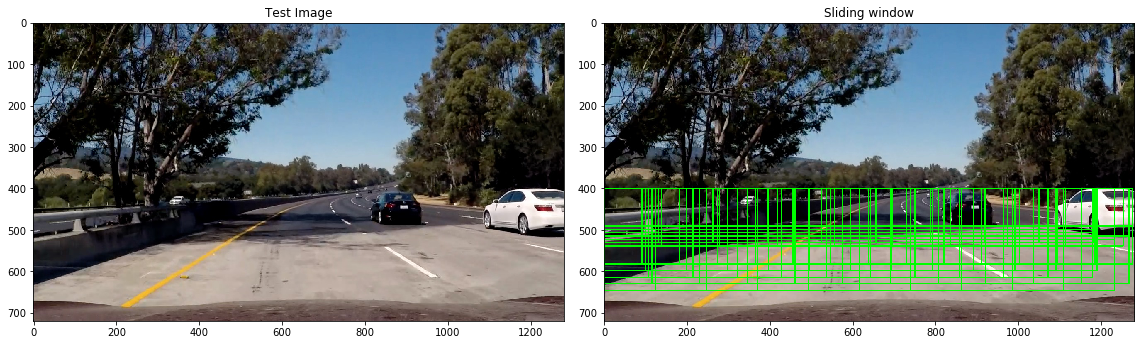

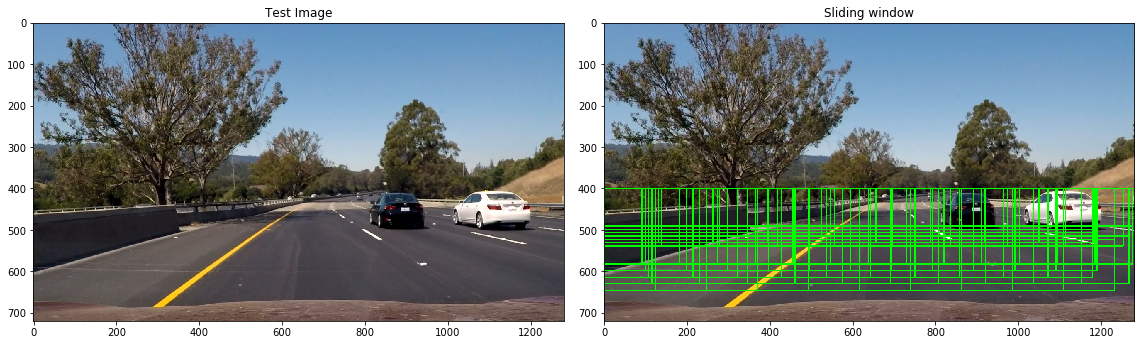

In [33]:
plotsliding(test_images)

In [39]:
def plotimage(test_images):
    from scipy.ndimage.measurements import label
    # Read in image similar to one shown above 
    mask_images = []
    for img in test_images:
        box_list = predictcar(img)
        image = mpimg.imread(img)
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        
        # mask images for smoothing
        mask = np.zeros_like(image)
        mask = draw_rectangle(mask, box_list, thick=-1)
        mask_images.append(mask)
        
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)

        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        fig = plt.figure(figsize=(16,9))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        
    return mask_images

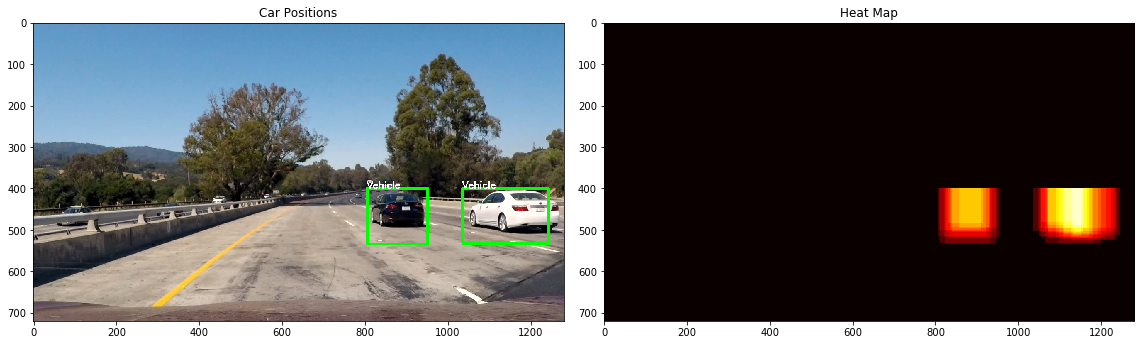

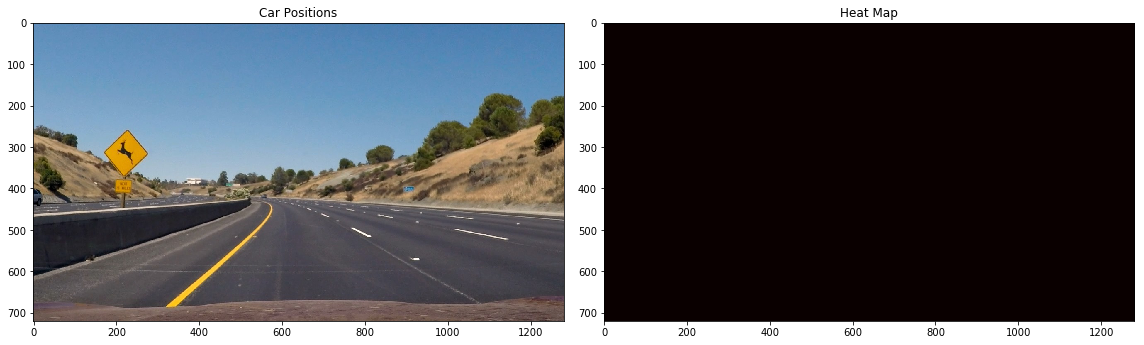

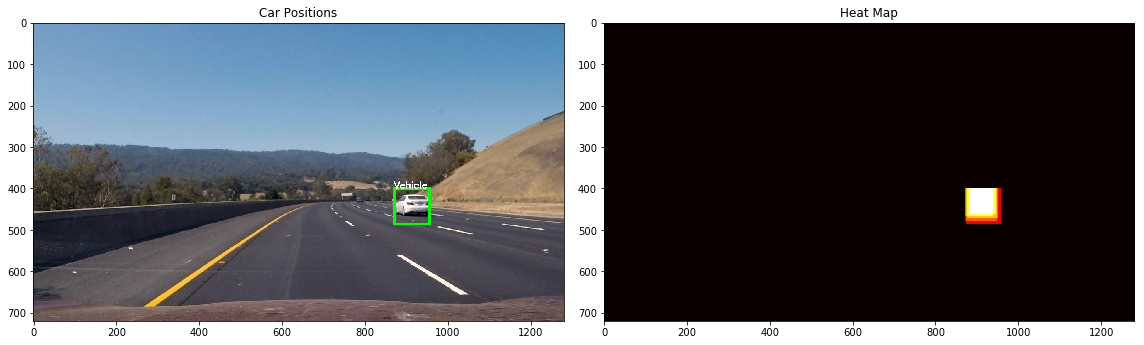

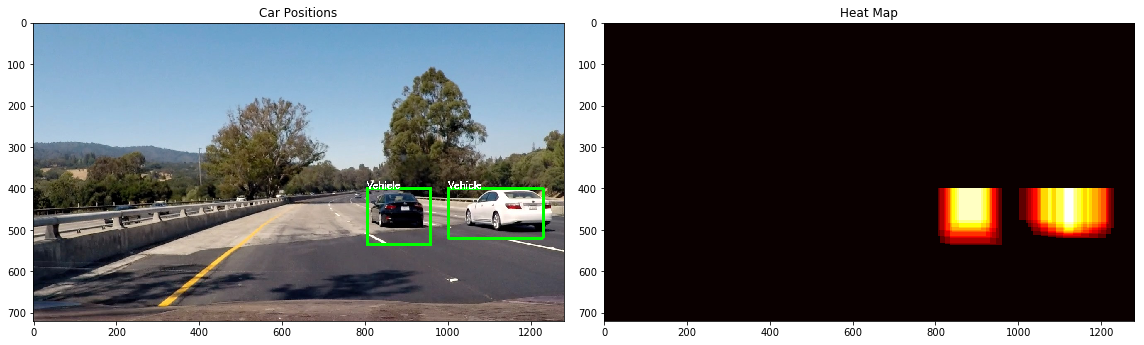

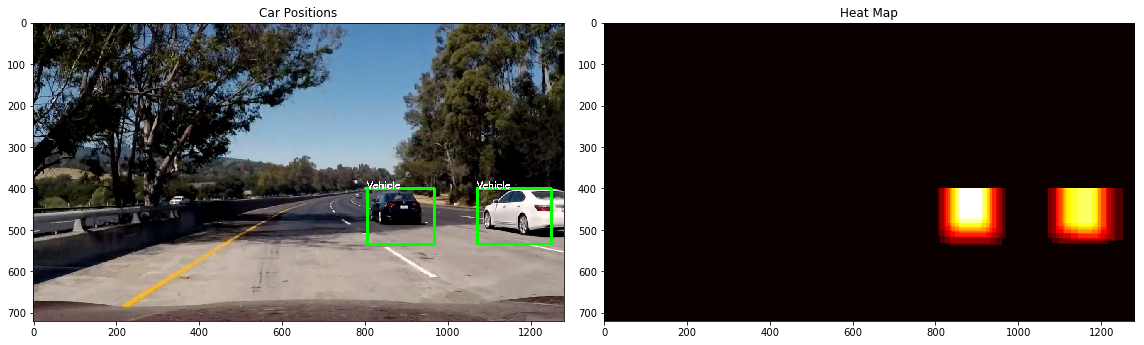

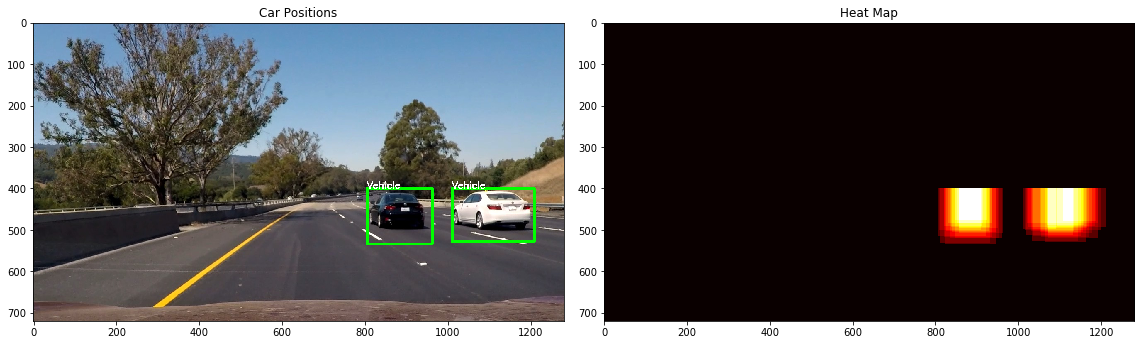

In [40]:
mask_images = plotimage(test_images)

In [67]:
# Extracting centroid, width and height information of an existing rectangle
def smoothboxes(mask_img):
    # Using open cv find contour function to determine rectangle positions
    im2, contours, hierarchy = cv2.findContours(mask_img[:,:,1].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    rect_list = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        print (x,y,w,h)
        rect_list.append([x,y,w,h])
    return rect_list

In [1]:
from vehicleDetector.vehicledetect import Detector
from moviepy.editor import VideoFileClip

clf_path = "classifier.pkl"
x_scaler = "X_Scaler.pkl"
project_video = "test_video.mp4"
project_output = "test_video_out.mp4"

# create an object of detector
vdectector = Detector(clf_path, x_scaler, prob_detect_thresh=0.995, win_start=320, win_incr=16, colourspace='YUV',
                     fp_threshold=3)
clip1 = VideoFileClip(project_video)
project_clip = clip1.fl_image(vdectector.process_main)
project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 



In [1]:
from vehicleDetector.vehicledetect import Detector
from moviepy.editor import VideoFileClip

clf_path = "classifier.pkl"
x_scaler = "X_Scaler.pkl"
project_video = "project_video.mp4"
project_output = "project_video_out.mp4"

# create an object of detector
vdectector2 = Detector(clf_path, x_scaler, prob_detect_thresh=0.996, win_start=320, win_incr=16, colourspace='YUV',
                       fp_threshold=3)
clip2 = VideoFileClip(project_video)
project_clip2 = clip2.fl_image(vdectector2.process_main)
project_clip2.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [12:10<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [1]:
import sys
sys.path.append("../CarND-Advanced-Lane-Lines")
from lanedetector.lanepipe import laneDetector
from moviepy.editor import VideoFileClip
import glob
import os
import numpy as np

# Peform Camera Calibration
chessimg = glob.glob(os.path.join('../CarND-Advanced-Lane-Lines/camera_cal', 'calibration*.jpg'))

# Create an Object of Lane Detector
src = np.float32([[575,465], [707,465], [260,685], [1050,685]])
dst = np.float32([[450, 0], [830, 0], [450, 720], [830, 720]])
LaneDetector = laneDetector(src, dst)
LaneDetector.calibrate_camera(chessimg)

Lane Detector : Camera Calibration Completed


In [2]:
from vehicleDetector.vehicledetect import Detector
from moviepy.editor import VideoFileClip

clf_path = "classifier.pkl"
x_scaler = "X_Scaler.pkl"
project_video = "project_video.mp4"
project_output = "project_video_combined.mp4"

# create an object of detector
vdectector2 = Detector(clf_path, x_scaler, prob_detect_thresh=0.996, win_start=320, win_incr=16, colourspace='YUV',
                      fp_threshold=3, lanefinding=True, lanedetector=LaneDetector)
clip2 = VideoFileClip(project_video)
project_clip2 = clip2.fl_image(vdectector2.process_main)
project_clip2.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_combined.mp4
[MoviePy] Writing video project_video_combined.mp4


100%|█████████▉| 1260/1261 [30:41<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_combined.mp4 

